## PCA with a linear Autoencoder

In [2]:
import numpy.random as rnd
import numpy as np

rnd.seed(4)
m = 200
w1, w2= 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m,3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) /2
data[:, 2] = data[:, 0] * w1 + data[:,1] * w2 + noise * rnd.randn(m)

In [3]:
# normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
# building the autoencoder
import tensorflow as tf

tf.reset_default_graph()
np.random.seed(42)

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [7]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test})

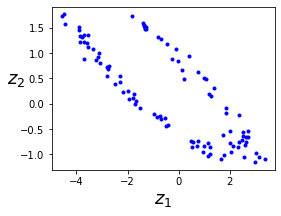

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1],"b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$",fontsize=18, rotation=0)
plt.show()

## stacked autoencoder

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

W0622 06:30:42.914431 18372 deprecation.py:323] From <ipython-input-12-7187608d1af6>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0622 06:30:42.915430 18372 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0622 06:30:42.917428 18372 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instru

Extracting /tmp/data\train-images-idx3-ubyte.gz


W0622 06:30:43.171743 18372 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


## Training all layers at once


In [14]:
# we will build a stacked Autoencoder with 3 hidden layers 
# and one output layer
# we will use ELU activation, He initialisation and L2 regularisation

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import  partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate =0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32,shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2)
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss =tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


W0622 06:52:53.251598 18372 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [18]:
# training
# this is unsupervised as we not feeding y_batch
import os

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end= "")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layer.ckpt")

0 Train MSE: 0.020573236
1 Train MSE: 0.011459848
2 Train MSE: 0.0102288425
3 Train MSE: 0.009903775
4 Train MSE: 0.010379946


In [21]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")

In [23]:
def plot_multiple_images(images,n_roes, n_cols, pad=2):
    images = images - images.min() 
    # making the minimum look zero so that the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad)* n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y * (h + pad) + pad): (y * (h + pad) + pad + h), (x * (w + pad) + pad):(x * (w + pad) + pad + w)] = images[y * n_cols + x]
        plt.imshow(image, cmap="Greys", interpolation="nearest")
    

In [26]:
def show_reconstructed_digits(X, outputs, model_path=None,n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
    
    fig = plt.figure(figsize=(8,3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2+ 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

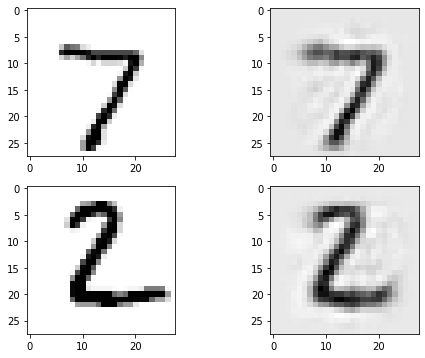

In [27]:
show_reconstructed_digits(X, outputs, "./my_model_all_layer.ckpt")

## Tying wieghts

In [28]:
# its common to tie the weights of encoder and decoder, but ut makes very difficult to use tf.layer.dense
# so we build the autoencoder manually

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1= 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [ ]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")